In [329]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

def boxplot_sorted(df, by, column, rot=0):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df2.median().sort_values()
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    boxprops = dict(linewidth=2)
    return df2[meds.index].boxplot(rot=rot, return_type="axes", figsize=(20,10), boxprops=boxprops)


df = pd.read_csv("data/data.csv")

### Boxplot of RTT by origin country (where content is accessed)

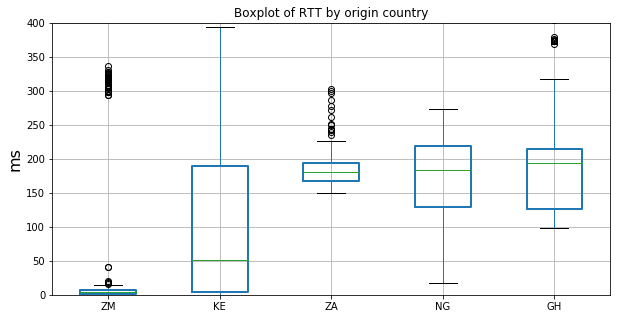

In [114]:
df1 = df.iloc[:,[2,15]]

axes = boxplot_sorted(df1, by=["vantageCC"], column="rtt")
axes.figure.set_size_inches(10,5)
axes.set_title("Boxplot of RTT by origin country")
axes.set_ylim([0,400])
axes.set_ylabel("ms", fontsize=16)

plt.savefig("data/plots/boxplot_rtt.svg")
plt.show()

## Boxplot of RTT by destination country (where content is hosted)

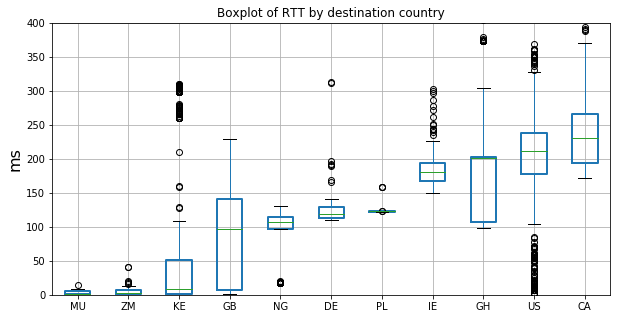

In [115]:
df2 = df.iloc[:,[6,15]]

axes = boxplot_sorted(df2, by=["destCC"], column="rtt")
axes.figure.set_size_inches(10,5)
axes.set_title("Boxplot of RTT by destination country")
axes.set_ylim([0,400])
axes.set_ylabel("ms", fontsize=16)

plt.savefig("data/plots/boxplot_rtt_dest.svg")
plt.show()

## CDF of RTT in between countries

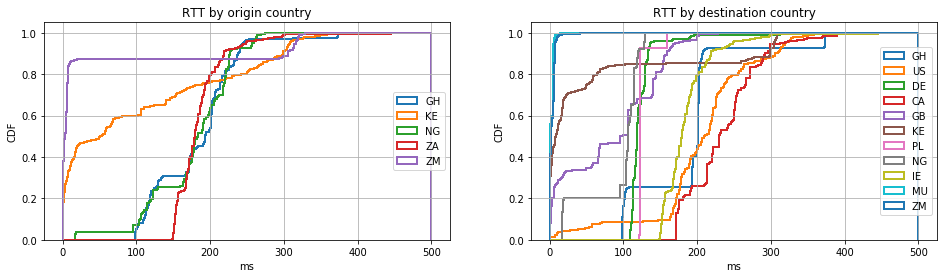

In [116]:
df_cc_origin = df1['vantageCC'].drop_duplicates()
df_cc_dest = df2['destCC'].drop_duplicates()

n_bins = 500

fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2)

for index, cc in df_cc_origin.iteritems():
    # plot the cumulative histogram
    array = df1.loc[df1['vantageCC']==cc].iloc[:,[1]].values
    
    ax1.hist(array, n_bins, normed=1, histtype='step', range=[0, 500], linewidth=2, 
                           cumulative=True, label=cc)

# tidy up the figure
ax1.grid(True)
ax1.legend(loc='right')
ax1.set_title('RTT by origin country')
ax1.set_xlabel('ms')
ax1.set_ylabel('CDF')

for index, cc in df_cc_dest.iteritems():
    # plot the cumulative histogram
    array = df2.loc[df2['destCC']==cc].iloc[:,[1]].values
    
    ax2.hist(array, n_bins, normed=1, histtype='step', range=[0, 500], linewidth=2, 
                           cumulative=True, label=cc)
    
# tidy up the figure
ax2.grid(True)
ax2.legend(loc='right')
ax2.set_title('RTT by destination country')
ax2.set_xlabel('ms')
ax2.set_ylabel('CDF')

plt.savefig("data/plots/cdf_rtt_cc.svg")
plt.show()


## RTT by hosting providers

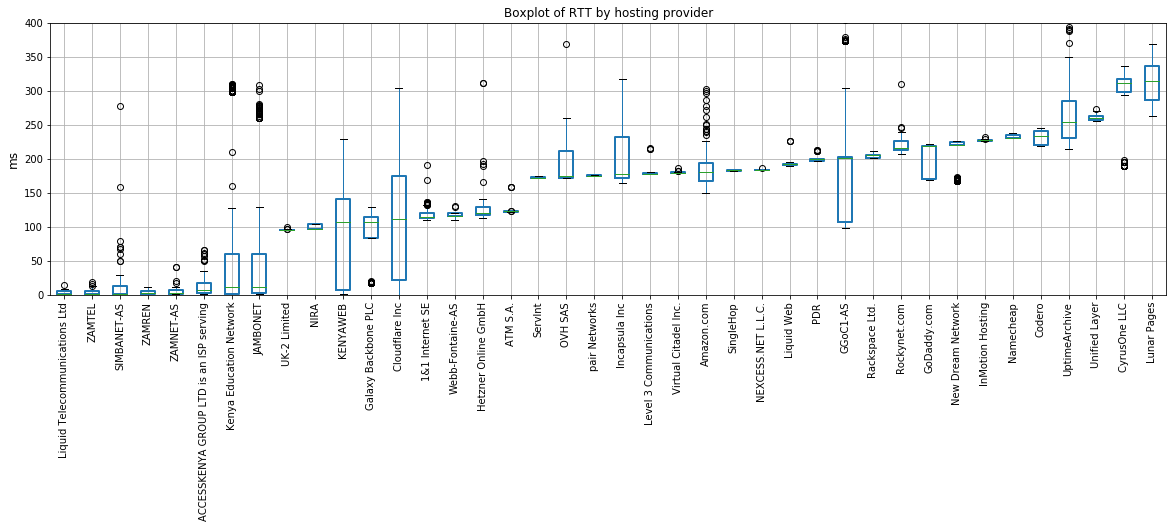

In [117]:
df3 = df.iloc[:,[9,15]]

axes = boxplot_sorted(df3, by=["hostCo"], column="rtt")
axes.figure.set_size_inches(20,5)
axes.set_title("Boxplot of RTT by hosting provider")
axes.set_ylim([0,400])
axes.set_ylabel("ms", fontsize=12)
plt.xticks(rotation=90)

plt.savefig("data/plots/hostCo_rtt.svg")
plt.show()

### Distribution of websites Locally hosted, Remotely hosted

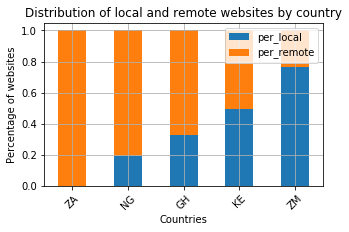

In [217]:
df4 = df.iloc[:,[2,10]]

df4 = df4.groupby(['vantageCC', 'remote']).size().reset_index(name='counts')
df4 = df4.pivot('vantageCC', 'remote').fillna(0)

#df4_local = pd.DataFrame(columns=['vantageCC', 'local'])
#df4_remote = pd.DataFrame(columns=['vantageCC', 'remote'])

df4 = pd.DataFrame(list(df4.itertuples()))
df4.columns = ['vantageCC', 'local','remote']

df4['total'] = df4.sum(axis=1)

df4['per_local'] = df4['local'].div(df4['total'])
df4['per_remote'] = df4['remote'].div(df4['total'])

df4 = df4.iloc[:,[0,4,5]]

df4 = df4.sort_values(by='per_local', ascending=True)


df4.plot.bar(stacked=True, figsize=(5,3), x='vantageCC', rot=45, fontsize=10)
plt.ylabel('Percentage of websites')
plt.grid(True)
plt.title("Distribution of local and remote websites by country")
plt.xlabel('Countries')
plt.savefig("data/plots/distribution_website_local_vs_remote.svg")
plt.show()

## Matrix of mean latency between countries

   vantageCC destCC         rtt
0         GH     CA  189.157068
1         GH     DE  124.418725
2         GH     GH  188.049489
3         GH     US  217.871756
4         KE     CA  270.634775
5         KE     GB   83.874262
6         KE     KE   58.059327
7         KE     US  174.034937
8         NG     GB   96.043056
9         NG     NG   92.714489
10        NG     PL  125.323857
11        NG     US  205.515280
12        ZA     IE  186.068698
13        ZM     MU    3.017933
14        ZM     US  313.464690
15        ZM     ZM    4.121667


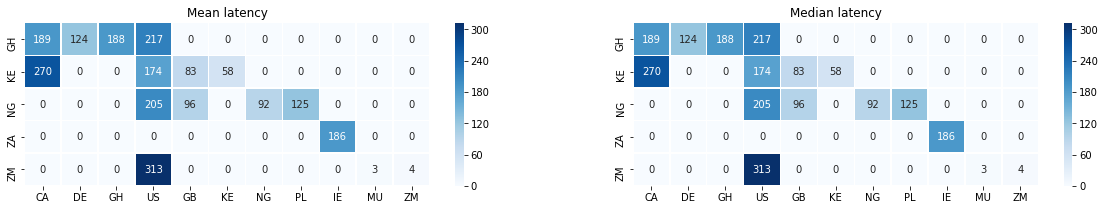

In [344]:
df5 = df.iloc[:, [2, 6, 15]]
df5_mean = df5.groupby(['vantageCC', 'destCC'], as_index=False).mean()
df5_median = df5.groupby(['vantageCC', 'destCC'], as_index=False).median()

Index = df5.iloc[:,[0]].drop_duplicates()['vantageCC'].values
Cols = df5.iloc[:,[1]].drop_duplicates()['destCC'].values

w = len(Index)
h = len(Cols)

Matrix_mean = np.zeros(shape=(w,h), dtype=int)
Matrix_median = np.zeros(shape=(w,h), dtype=int)

for i in range(w):
      for j in range(h):
        v_mean = df5_mean[(df5_mean.vantageCC==Index[i]) & (df5_mean.destCC==Cols[j])]['rtt']
        v_median = df5_median[(df5_median.vantageCC==Index[i]) & (df5_median.destCC==Cols[j])]['rtt']
        if (len(v_mean.values > 0)):
            Matrix_mean[i,j] = int(v_mean.values[0])
        if (len(v_median.values > 0)):
            Matrix_median[i,j] = int(v_median.values[0])
        #print str(i) + "|" + str(j)
          #Matrix[i,j] = df5[(df5.vantageCC==Index[i]) & (df5.destCC==Cols[j])]['rtt']
             #np.insert(Matrix, j, df5[(df5.vantageCC==Index[i]) & (df5.destCC==Cols[j])]['rtt'] , i)
# data = abs(np.random.randn(5, 11))
df_matrix_mean = DataFrame(Matrix_mean, index=Index, columns=Cols)
df_matrix_median = DataFrame(Matrix_median, index=Index, columns=Cols)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,3))
ax1.set_title("Mean latency")
ax2.set_title("Median latency")

sns.heatmap(ax=ax1, cmap='Blues', linewidths=0.5, data=df_matrix_mean, annot=True, fmt='g')
sns.heatmap(ax=ax2, cmap='Blues', linewidths=0.5, data=df_matrix_median, annot=True, fmt='g')